In [3]:
# Import libraries

# basic libraries
import pandas as pd
import numpy as np
import math

# data visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import altair as alt
import plotly.graph_objs as go
import plotly.express as px
import geopandas as gpd
import folium

# working with SQL
import psycopg2
import sqlalchemy as sa
from   sqlalchemy.engine import URL
from   sqlalchemy import text

# working with time series
import matplotlib.dates as mdates
from datetime import date, time, datetime


# statistical computation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# make sure each time the random generation gives the same result
np.random.seed(1234)

In [4]:
# import data sets
drivers = pd.read_csv("data_raw/drivers.csv")
driver_standings = pd.read_csv("data_raw/driver_standings.csv")
races = pd.read_csv("data_raw/races.csv")

In [5]:
# join drivers and driver standings

driver_join = pd.merge(drivers[["driverId", "forename", "surname", "nationality"]],
                       driver_standings[["raceId", "driverId", "points", "wins"]],
                       how = "left",
                       on = "driverId")

In [6]:
driver_nationality = (driver_join.groupby("nationality")
                                 .agg(sum_wins = ("wins", "sum"))
                                 .query("sum_wins != 0")
                                 .sort_values("sum_wins", ascending = False)
                                 .reset_index())

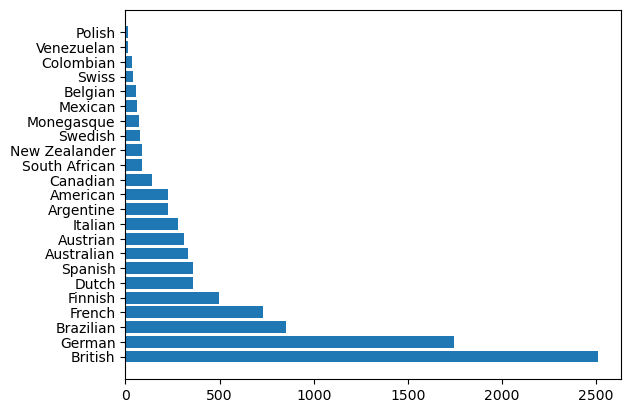

In [7]:
plt.barh(range(len(driver_nationality)), driver_nationality["sum_wins"], tick_label = driver_nationality["nationality"])
plt.show()

<AxesSubplot: xlabel='sum_wins', ylabel='nationality'>

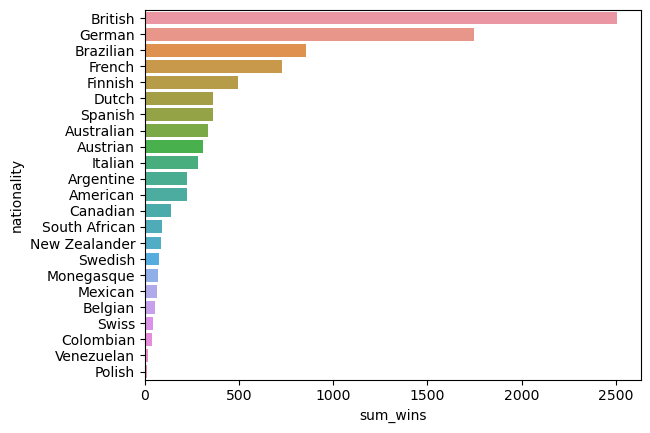

In [8]:
# Using seabron
sns.barplot(data = driver_nationality, y = "nationality", x = "sum_wins")

In [9]:
# Use alt
bar = alt.Chart(driver_nationality).mark_bar().encode(
    x = "nationality",
    y = "sum_wins"
)
bar.show()

Displaying chart at http://localhost:60612/


In [10]:
barplot = px.bar(driver_nationality, x = "nationality", y = "sum_wins")

barplot.show()

In [40]:
nationality_to_nation = {"British": "United Kingdom",
                         "German" : "Germany",
                         "Brazilian": "Brazil",
                         "French": "France",
                         "Finnish" : "Finland",
                         "Dutch" : "Denmark",
                         "Spanish": "Spain",
                         "Australian": "Australia",
                         "Austrian" : "Austria",
                         "Italian" : "Italy",
                         "Argentine" : "Argentina",
                         "American" : "United States of America",
                         "Canadian" : "Canada",
                         "South African" : "South Africa",
                         "New Zealander" : "New Zealand",
                         "Swedish" : "Sweden",
                         "Monegasque" : "Monaco",
                         "Mexican" : "Mexico",
                         "Belgian" : "Belgium",
                         "Swiss" : "Switzerland",
                         "Colombian" : "Colombia",
                         "Venezuelan" : "Venezuela",
                         "Polish" : "Poland"}

driver_nationality = driver_nationality.replace(nationality_to_nation)

In [41]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

driver_nationality_gpd = world.merge(driver_nationality, left_on = "name", right_on = "nationality")

In [42]:
driver_nationality_map = folium.Map(location = [0, 0], zoom_start = 2)

folium.Choropleth(geo_data = driver_nationality_gpd,
                  name = "choropleth",
                  data = driver_nationality,
                  columns = ["nationality", "sum_wins"],
                  key_on = "feature.properties.name",
                  fill_color = "YlGn",
                  fill_opacity = 0.7,
                  line_opacity = 0.2,
                  legend_name = "sum_wins").add_to(driver_nationality_map)

folium.LayerControl().add_to(driver_nationality_map)

driver_nationality_map

In [124]:
list_nationality = list(driver_nationality.iloc[:5,0])

driver_join_top = driver_join[driver_join["nationality"].isin(list_nationality)]

In [125]:
season_join = pd.merge(driver_join_top,
                       races[["raceId", "year"]],
                       how = "left",
                       on = "raceId")

In [138]:
season_year_Id = (season_join.query("year >= 2000")
                          .groupby(["year", "driverId"])
                          .agg(sum_wins = ("wins", "sum"))
                          .query("sum_wins != 0")
                          .reset_index())

In [139]:
season_year_wide = (pd.pivot(season_year_Id,
                       index = "year",
                       columns = "driverId",
                       values = "sum_wins")
                      .reset_index())

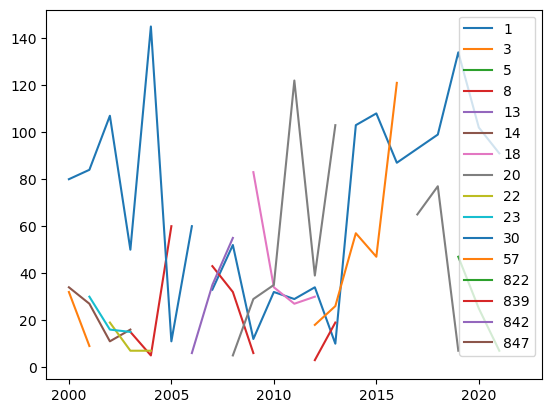

In [140]:
list_columns = list(season_year_wide.columns)
list_columns.remove("year")

for i in list_columns: 
    plt.plot(season_year_wide["year"], season_year_wide[i])
plt.legend(list_columns)
plt.show()

<AxesSubplot: xlabel='year', ylabel='sum_wins'>

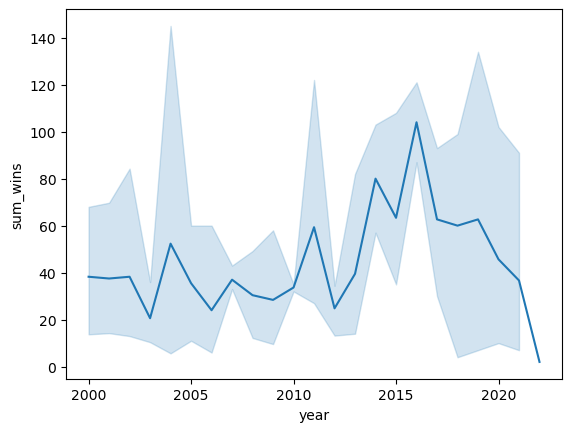

In [142]:
# Using seaborn
sns.lineplot(x = "year", y = "sum_wins", data = season_year_Id)

In [144]:
lineplotly = px.line(season_year_Id, x="year", y = "sum_wins", color = "driverId")

lineplotly.show()

In [145]:
season_year_nationality = (season_join.query("year >= 2000")
                                      .groupby(["year", "nationality"])
                                      .agg(sum_wins = ("wins", "sum"))
                                      .query("sum_wins != 0")
                                      .reset_index())

In [146]:
lineplotly = px.line(season_year_nationality, x = "year", y = "sum_wins", color = "nationality")

lineplotly.show()